## Calc de gradient vector for a cavity. HI PRECISION

### Desplazamientos entre -2 y 2

In [1]:
using DataFrames
using Gadfly
using Cairo
using MIToS.PDB
using Compose
using Distributions
set_default_plot_size(40cm, 14cm)

In [2]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [3]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [4]:
function read_ptraj_modes(file, modes_elements, nmodes::Int64=0, norma::Bool=true)    

    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    comments=true, comment_char='\*')
    close(modes_file)

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 3 methods)

In [5]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [6]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [7]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
prt_name = "1m14"
avg_1_filename = string("/home/german/labo/16/rtas_a_reviewers/cvgcia/1cavities/bu/1cut_avg_",
    prt_name, ".pdb")
avg_2_filename = string("/home/german/labo/16/rtas_a_reviewers/cvgcia/2cavities/bu/2cut_avg_",
    prt_name, ".pdb")
avg_1_pdb = read(avg_1_filename, PDBFile, group="ATOM");
avg_2_pdb = read(avg_2_filename, PDBFile, group="ATOM");

# Obtengo el número de átomos de c/ residuo
for i=1:length(avg_1_pdb)
    push!(natom_res, length(avg_1_pdb[i]))
end
shift!(natom_res)

# Obtengo el nro de aa's
aa = length(avg_1_pdb)
aa3 = aa * 3

# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn = Array{Float64}(aa3-6);
vol_ndd = Array{Float64, 2}(0, 2);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1_filename = string("/home/german/labo/16/rtas_a_reviewers/cvgcia/1m14/1modes_1m14")
modes_2_filename = string("/home/german/labo/16/rtas_a_reviewers/cvgcia/1m14/2modes_1m14")
modes_prt_1, evals_prt_1 = read_ptraj_modes(modes_1_filename, aa3);
modes_prt_2, evals_prt_2 = read_ptraj_modes(modes_2_filename, aa3);

# Template p/ pdbs de salida
files_1_template = "/home/german/labo/16/rtas_a_reviewers/cvgcia/1cavities/1m14/"
files_2_template = "/home/german/labo/16/rtas_a_reviewers/cvgcia/2cavities/1m14/"
# Archivos de config de ANA
conf_1_prt_whole = "/home/german/labo/16/rtas_a_reviewers/cvgcia/1cavities/bu/1_1m14.cfg"
conf_2_prt_whole = "/home/german/labo/16/rtas_a_reviewers/cvgcia/2cavities/bu/1_1m14.cfg"

"/home/german/labo/16/rtas_a_reviewers/cvgcia/2cavities/bu/2_1m14.cfg"

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por -2 y 2; y así obtener distintos desplazamientos. Creando así 2 sets, c/u de 339 estructuras desplazadas (1 por c/ modo)

In [27]:
modo_sum = Array{Float64}(aa, 3);
factorr = Array{Float64}(aa3-6);
constant = 3
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-2 2]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_prt_1[i*3-2, j]
            modo_sum[i, 2] = modes_prt_1[i*3-1, j]
            modo_sum[i, 3] = modes_prt_1[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1
                temp1_modo_sum = repmat(transpose(modo_sum[1, :]), natom_res[i])
                continue
            end
            temp2_modo_sum = repmat(transpose(modo_sum[i, :]), natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
        modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factorr[j] = magnitude * constant * 1/evals_prt_1[j]
# Modifico las coordenadas
        m14_atom_xyz = coordinatesmatrix(avg_1_pdb)
        new_m14_atom_xyz = m14_atom_xyz + modo_sum .* factorr[j];
# Obtengo un nuevo frame con las coordenadas modificadas
        new_pdb_pdb = change_coordinates(avg_1_pdb, new_m14_atom_xyz)
# Escribo el nuevo .pdb
        pdb_m14 = string(files_1_template, displacement, "/", "mod", j, "_", displacement, "_m14.pdb")
        write(pdb_m14, new_pdb_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal, largo y whole p/ los 2 sets de 345 estructuras desplazadas. Y así junto 2 sets (1 por c/ magnitud de desplazamiento) de 4 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal, largo y whole a c/u de los elementos de los 8 vectores y así obtengo 2 sets de 4 vectores gradiente en base de coordenadas cartesianas.

In [28]:
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_1_template, displacement, "/inndd_", prt_name, "_", displacement)
    ndd_output_filename = string(files_1_template, displacement, "/1_outndd_", prt_name, "_", displacement)
    
    # WHOLE
    global vol_ndd = Symbol("vol_ndd_whole_", displacement)
    global gdte_ndd = Symbol("gdte_ndd_whole_", displacement)  
    # Calculo el pocket        
    run(`ANA $avg_1_filename -c $conf_1_prt_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readstring(`ANA $avg_1_filename -c $conf_1_prt_whole`)[10:end-2]))
end

883.713
883.713


### Finalmente, obtengo el vector gradiente

In [29]:
# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo.
gdte_whole_1 = (vol_ndd_whole_d2 - vol_ndd_whole_d_2) .* evals_prt_1;

# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
gdte_whole_1 = gdte_whole_1 / norm(gdte_whole_1);

## 2da mitad

In [30]:
modo_sum = Array{Float64}(aa, 3);
factorr = Array{Float64}(aa3-6);
constant = 3
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-2 2]

    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_prt_2[i*3-2, j]
            modo_sum[i, 2] = modes_prt_2[i*3-1, j]
            modo_sum[i, 3] = modes_prt_2[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1
                temp1_modo_sum = repmat(transpose(modo_sum[1, :]), natom_res[i])
                continue
            end
            temp2_modo_sum = repmat(transpose(modo_sum[i, :]), natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
        modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factorr[j] = magnitude * constant * 1/evals_prt_2[j]
# Modifico las coordenadas
        hvr_apo_atom_xyz = coordinatesmatrix(avg_2_pdb)
        new_hvr_apo_atom_xyz = hvr_apo_atom_xyz + modo_sum .* factorr[j];
# Obtengo un nuevo frame con las coordenadas modificadas
        new_pdb_pdb = change_coordinates(avg_2_pdb, new_hvr_apo_atom_xyz)
# Escribo el nuevo .pdb
        pdb_hvr_apo = string(files_2_template, displacement, "/", "mod", j, "_", displacement, "_hvr_apo.pdb")
        write(pdb_hvr_apo, new_pdb_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal, largo y whole p/ los 2 sets de 345 estructuras desplazadas. Y así junto 2 sets (1 por c/ magnitud de desplazamiento) de 4 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal, largo y whole a c/u de los elementos de los 8 vectores y así obtengo 2 sets de 4 vectores gradiente en base de coordenadas cartesianas.

In [31]:
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_2_template, displacement, "/inndd_", prt_name, "_", displacement)
    ndd_output_filename = string(files_2_template, displacement, "/1_outndd_", prt_name, "_", displacement)
    
    # WHOLE
    global vol_ndd = Symbol("vol_ndd_whole_", displacement)
    global gdte_ndd = Symbol("gdte_ndd_whole_", displacement)  
    # Calculo el pocket        
    run(`ANA $avg_2_filename -c $conf_2_prt_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readstring(`ANA $avg_2_filename -c $conf_2_prt_whole`)[10:end-2]))
end

826.502
826.502


In [32]:
# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo.
gdte_whole_2 = (vol_ndd_whole_d2 - vol_ndd_whole_d_2) .* evals_prt_2;

# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
gdte_whole_2 = gdte_whole_2 / norm(gdte_whole_2);

----------------------

# B: los 1eros "pnumber" modos

### Me quedo con los Pnumber modos, elementos de gradiente, frecuencias, colectividades y Pnumber de c/ modo

In [33]:
# Obtengo el pnumber
pnumber_gdte_1 = convert(Int64, round(sum(gdte_whole_1 .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_1 = sortperm(abs.(gdte_whole_1), rev=true)[1:pnumber_gdte_1]
indices_pnum_modes_1 = sort(indices_pnum_modes_1)

# Ahora recorto los modos, el gradiente, las frecuencias, las colectividades, los pnumber

# Me quedo con los "pnumber" modos. Uso los modos q ya fueron rellenados
modes_prt_pnum_1 = modes_prt_1[:, indices_pnum_modes_1];

# Me quedo con los ∇Volumen de los "pnumber" modos
gdte_whole_pnum_1 = gdte_whole_1[indices_pnum_modes_1];
# Me quedo con las frequencias de los "pnumber" modos
evals_prt_pnum_1 = evals_prt_1[indices_pnum_modes_1];

### Según frecuencia

In [34]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_freq_Whis

# Los bins van de 0 a la fqcia más alta + 10%
top_freq_1 = maximum(evals_prt_pnum_1) * 1.1
bins_freq_1 = collect(0:50:top_freq_1)
unos_freq_1 = repeat([1.0], inner=[length(evals_prt_pnum_1)])

# Histograma no ponderado
mode_freq_his_1, mode_freq_bins_1 = WeightedHist(evals_prt_pnum_1, bins_freq_1, unos_freq_1, true);
df_mode_freq_pnum_his_1 = DataFrame(Probability = mode_freq_his_1, Frequency = mode_freq_bins_1);

# Histograma ponderado
mode_freq_Whis_1, mode_freq_Wbins_1 = WeightedHist(evals_prt_pnum_1, bins_freq_1, abs.(gdte_whole_pnum_1), true);
df_mode_freq_pnum_Whis_1 = DataFrame(Probability = mode_freq_Whis_1, Frequency = mode_freq_Wbins_1);

# Histograma ponderado y dividido por densidad de estados
mode_freq_Whis_state_dens_1 = mode_freq_Whis_1 ./ mode_freq_his_1
# Fix some NaNs caused by "divide by zero" error
mode_freq_Whis_state_dens_1[isnan.(mode_freq_Whis_state_dens_1)] = 0
# Turn to density
mode_freq_Whis_state_dens_1 = mode_freq_Whis_state_dens_1 ./ sum(mode_freq_Whis_state_dens_1)
df_mode_freq_pnum_Whis_state_dens_1 = DataFrame(Probability = mode_freq_Whis_state_dens_1, Frequency = mode_freq_Wbins_1);

### Me quedo con los Pnumber modos, elementos de gradiente, frecuencias, colectividades y Pnumber de c/ modo

In [35]:
# Obtengo el pnumber
pnumber_gdte_2 = convert(Int64, round(sum(gdte_whole_2 .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_2 = sortperm(abs.(gdte_whole_2), rev=true)[1:pnumber_gdte_2]
indices_pnum_modes_2 = sort(indices_pnum_modes_2)

# Ahora recorto los modos, el gradiente, las frecuencias, las colectividades, los pnumber

# Me quedo con los "pnumber" modos. Uso los modos q ya fueron rellenados
modes_prt_pnum_2 = modes_prt_2[:, indices_pnum_modes_2];

# Me quedo con los ∇Volumen de los "pnumber" modos
gdte_whole_pnum_2 = gdte_whole_2[indices_pnum_modes_2];
# Me quedo con las frequencias de los "pnumber" modos
evals_prt_pnum_2 = evals_prt_2[indices_pnum_modes_2];

### Según frecuencia

In [36]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_freq_Whis

# Los bins van de 0 a la fqcia más alta + 10%
top_freq_2 = maximum(evals_prt_pnum_2) * 1.1
bins_freq_2 = collect(0:50:top_freq_2)
unos_freq_2 = repeat([1.0], inner=[length(evals_prt_pnum_2)])

# Histograma no ponderado
mode_freq_his_2, mode_freq_bins_2 = WeightedHist(evals_prt_pnum_2, bins_freq_2, unos_freq_2, true);
df_mode_freq_pnum_his_2 = DataFrame(Probability = mode_freq_his_2, Frequency = mode_freq_bins_2);

# Histograma ponderado
mode_freq_Whis_2, mode_freq_Wbins_2 = WeightedHist(evals_prt_pnum_2, bins_freq_2, abs.(gdte_whole_pnum_2), true);
df_mode_freq_pnum_Whis_2 = DataFrame(Probability = mode_freq_Whis_2, Frequency = mode_freq_Wbins_2);

# Histograma ponderado y dividido por densidad de estados
mode_freq_Whis_state_dens_2 = mode_freq_Whis_2 ./ mode_freq_his_2
# Fix some NaNs caused by "divide by zero" error
mode_freq_Whis_state_dens_2[isnan.(mode_freq_Whis_state_dens_2)] = 0
# Turn to density
mode_freq_Whis_state_dens_2 = mode_freq_Whis_state_dens_2 ./ sum(mode_freq_Whis_state_dens_2)
df_mode_freq_pnum_Whis_state_dens_2 = DataFrame(Probability = mode_freq_Whis_state_dens_2, Frequency = mode_freq_Wbins_2);

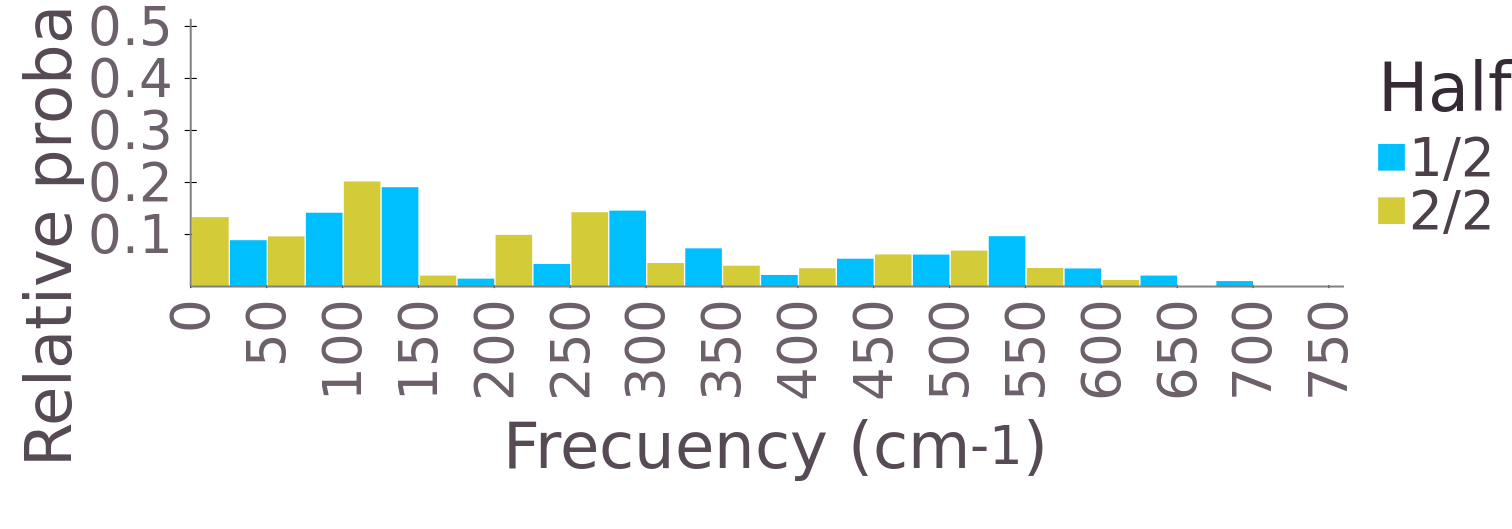

In [40]:
df_mode_freq_pnum_Whis = DataFrame(
    Probability = [ df_mode_freq_pnum_Whis_1[:, 1] ; df_mode_freq_pnum_Whis_2[:, 1][1:end-1] ],
    Frequency = [ df_mode_freq_pnum_Whis_1[:, 2] ; df_mode_freq_pnum_Whis_2[:, 2][1:end-1] ],
    Half = repeat([ "1/2" ; "2/2" ], inner = [15]));

lyr_x_ticks = layer(x =  collect(0:50:775), xend = collect(0:50:775),
            y = repeat([-0.003], inner = [16]), yend = repeat([0.003], inner = [16]),
            Geom.segment, Theme(default_color=colorant"Black"))
lyr_y_ticks = layer(y =  collect(0.1:0.1:.5), yend = collect(0.1:0.1:.5),
            x = repeat([-4], inner = [5]), xend = repeat([4], inner = [5]),
            Geom.segment, Theme(default_color=colorant"Black"))

lyr_mode_freq_pnum_Whis = layer(df_mode_freq_pnum_Whis, x="Frequency", y="Probability", color = "Half",
    Geom.bar(position=:dodge))
    

plot_2a_fig = plot(lyr_mode_freq_pnum_Whis, lyr_x_ticks, lyr_y_ticks,

Guide.annotation(compose(context(), line([(0., 0.), (760, 0.), ]),
Compose.stroke("gray"), Compose.fill("gray") )),
Guide.annotation(compose(context(), line([(0., 0.), (0., 0.52), ]),
Compose.stroke("gray"), Compose.fill("gray") )),

Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("Relative probability", orientation=:vertical),
Coord.cartesian(ymax = 0.5, xmax = 775), Guide.yticks(ticks = collect(0.1:0.1:.5)),
Theme(bar_spacing=2pt, grid_line_width=0pt, default_color=colorant"LightSalmon",
    minor_label_font_size = 40pt, major_label_font_size = 48pt, key_title_font_size = 50pt,
    key_label_font_size = 40pt))

In [41]:
out_filename_2a_fig = string("/home/german/labo/16/rtas_a_reviewers/cvgcia/2a-fig_1m14_halves.png")
draw(PNG(out_filename_2a_fig, 60cm, 40cm), plot_2a_fig)

## Comparacion de gradientes

files_template_cart = string("/home/german/labo/16/cavities/cartesian/1m14/")
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_template_cart, displacement, "/inndd_", prt_name, "_", displacement)
    ndd_output_filename = string(files_template_cart, displacement, "/1_outndd_", prt_name, "_", displacement)
    
    # WHOLE
    global vol_ndd = symbol("vol_ndd_whole_cart_xyz", displacement)
    global gdte_ndd = symbol("gdte_ndd_whole_cart_xyz", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_prt_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_prt_whole`)[10:end-2]))
end

# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo.
gdte_whole_cart_xyz = (vol_ndd_whole_cart_xyzd2 - vol_ndd_whole_cart_xyzd_2)

# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
gdte_whole_cart_xyz = gdte_whole_cart_xyz / norm(gdte_whole_cart_xyz);
gdte_whole_cart = tognm(gdte_whole_cart_xyz);
cart_gdte_whole = tognm(modes_prt * gdte_whole)
dot(cart_gdte_whole, gdte_whole_cart)

## Datos q checkeo p/ hablar en el paper

sort(abs(gdte_whole), rev = true)[1:25];

temporal = abs(gdte_whole) / sum(abs(gdte_whole))
sort(abs(temporal), rev = true)[1:25]
temporal[4] / sum(temporal)

temporal = abs(gdte_whole_cart) / sum(abs(gdte_whole_cart));
sum(temporal[1:99])
# Residuos del monómero A en el VGV:

sum(temporal[100:end])
# Residuos del monómero B en el VGV: